In [1]:
%matplotlib inline

In [214]:
import time
from tqdm import tqdm
import numpy as np
from scipy.stats import multivariate_normal
from functools import partial

import torch
from torch import nn
from torch.optim import Optimizer, SGD
import torch.functional as F

from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt

import copy

## 5. Neural Network optimization using SGLD


Les réseaux de neurones Bayésiens forment une classe de modèles résolvant d'importants défauts des réseaux de neurones "classiques", notamment en **évitant le surapprentissage** et en permettant de **quantifier l'incertitude des modèles**. Il existe plusieurs types de réseaux de neurones Bayésiens, par exemple *Bayes by Backprop*.

Dans cette partie, nous utilisons SGLD pour optimiser les paramètres de réseaux de neurones peu profonds puis pour échantilloner selon la loi postérieure sur ces paramètres. 

Pour la loi prior sur les paramètres, nous utilisons une loi gaussienne centrée de variance $\sigma^2 I$. Nous réutilisons les pas utilisés précédemment, c'est à dire calculés selon :

$$
\varepsilon_t = \frac{a}{(b+t)^\gamma}
$$

Définissons tout d'abord notre réseau. Nous utilisons deux réseaux simples : un **perceptron avec une unique couche cachée**, et un **perceptron à une couche**, i.e. un modèle linéaire avec une sigmoide utilisée pour une prédiction binaire.

Enfin, pour tirer profit de l'échantillonnage sur les poids, un troisième modèle permet de créer un ensemble de modèles à partir des paramètres des modèles issus d'un certain nombre d'itérations de l'algorithme, typiquement toutes les itérations après le *burn-in*. Les prédictions sont faites en utilisant la moyenne des sorties des modèles.

In [87]:
class DenseNet(nn.Module):
    """
    Multi Layer Perceptron with one hidden layer. The activation function is either a ReLU or a Sigmoid, 
    and the last activation function is a sigmoid to allow for binary classification.
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

        self.activation = nn.ReLU()
        # self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        out = nn.Sigmoid()(x)

        return out

class SimpleDenseNet(nn.Module):
    """
    Simple one layer model with a sigmoid activation for binary classification.
    """
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.fc(x)
        out = nn.Sigmoid()(x)

        return out

class EnsembleNet(nn.Module):
    """
    This model allows to load the parameters of several models and create a new model per set of parameters, then perform inference by averaging predictions.
    """
    def __init__(self, params_history, Model, hparams):
        """
        Arguments:
            - params_history (list) : list of model parameters. There will be as many models created as there are items in this list.
            - Model (nn.Module) : the model class, used to instantiate each model.
            - hparams (dict) : hyperparameters used for the model.
        """
        super().__init__()

        models = []
        for param in params_history:
            newmodel = Model(**hparams)
            newmodel.load_state_dict(param)
            models.append(newmodel)
        self.models = nn.ModuleList(models)

    def forward(self, x):
        out = []
        with torch.no_grad():
            for model in self.models:
                out.append(model(x))
        out = torch.cat(out, dim=1)
        return out.mean(1)[:, None]

Une fois les modèles définis, nous pouvons créer l'optimiseur SGLD. Nous utilisons la structure de l'optimiseur SGD de PyTorch pour implémenter SGLD.

In [5]:
class SGLD(Optimizer):
    def __init__(self, params, lr, sigma_prior=1.):
        """
        Adapted from https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD.

        Arguments:
            - params: model parameters.
            - lr: initial learning rate.
            - sigma_prior: variance of the gaussian prior used for the weights.
        """
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if sigma_prior < 0.0:
            raise ValueError("Invalid prior variance: {}".format(sigma_prior))

        weight_decay = 1 / sigma_prior ** 2
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(SGLD, self).__init__(params, defaults)


    @torch.no_grad()
    def step(self):
        """
        Performs a single optimization step.
        """
        loss = None

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            lr = group['lr']

            for p in group['params']:
                if p.grad is not None:
                    d_p = p.grad.data

                    d_p.add_(weight_decay, p.data)

                    eta = p.data.new(p.data.size()).normal_(mean=0, std=1) / np.sqrt(lr)

                    p.data.add_(-lr, 0.5 * d_p + eta)
                    # p.data.add_(-lr, 0.5 * d_p)
                    # print(f"eta : {eta*lr}")
                    # print(f"d_p : {d_p.data}")
                    # print(p.data)

        return loss

In [204]:
def get_step_size(a, b, gamma, t):
    """
    Get the step size for parameters (a, b, gamma) at iteration t.
    Arguments:
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      t: int, iteration number
    Return:
      float, step_size
    """
    return a * (b + t) ** (- gamma)


def SGLD_nn(X, y, n_iter, a, b, gamma, batch_size, sigma_prior, model, N_models=1000):
    """
    Trains a simple neural network using SGLD.

    Arguments:
        - X (np.array): training features.
        - y (np.array): training labels.
        - n_iter (int): number of iterations of the optimization procedure.
        - a, b, gamma (floats): used for the step size computation.
        - batch_size (int): number of samples processed at each iterations.
        - sigma_prior (float): standard deviation of the gaussian prior used on the weights.
        - model (nn.Module)
        - N_models (int): number of model parameters to save.
    Return:
        - (nn.Module): the last trained model.
        - (list): losses suffered during training.
        - (list): list of N_models params.
    """

    start = time.time()

    y[y == -1] = 0
    N, dim = X.shape

    criterion = nn.BCELoss()
    opt = SGLD(model.parameters(), lr=a, sigma_prior=sigma_prior)
    # opt = SGD(model.parameters(), lr=1e-3)

    lambda_ = partial(get_step_size, 1, b, gamma)
    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lambda_)
    # lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=100, gamma=gamma)

    losses = []

    # We save parameter values of the network through iteration
    params = []

    model.train()
    for ii in tqdm(range(n_iter)):
                
        # select a batch of size batch_size
        idxs = np.random.choice(N, size=batch_size)
        batch_X = torch.tensor(X[idxs].astype(np.float32))
        batch_y = torch.tensor(y[idxs].reshape(-1, 1)).float()

        # Model output
        out = model(batch_X)
        loss = criterion(out, batch_y)

        # Compute gradients, optimize model
        loss.backward()
        opt.step()
        lr_scheduler.step()
        # print(lr_scheduler.get_lr())
        opt.zero_grad()

        # Save history
        losses.append(loss.item())

        if len(params) == N_models:
            params.pop(0)
        params.append(copy.deepcopy(model.state_dict()))


    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")

    return model, losses, params

Nous chargeons le premier jeu de données, linéairement séparable.

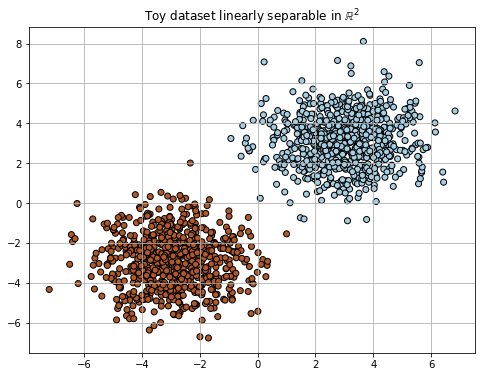

In [197]:
# load linearly separable dataset
X, y = make_blobs(n_samples=1500, centers=[(-3,-3),(3,3)], cluster_std=1.3, n_features=2, random_state=42)
y = 2 * y - 1

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Paired_r', edgecolors='k')
plt.title("Toy dataset linearly separable in $\mathbb{R}^2$")
plt.grid()
plt.show()

Lançons un entraînement sur 5000 itérations.

In [207]:
n_iter = 5000
batch_size = 50
a = 1e-1
b = 1
gamma = .7
sig = 100

model = DenseNet(input_size=2, hidden_size=4)
# model = SimpleDenseNet(input_size=2)

model, losses, params = SGLD_nn(X, y, n_iter, a, b, gamma, batch_size, sig, model, N_models=n_iter)

100%|██████████| 5000/5000 [00:08<00:00, 615.62it/s]


Done in 8.13 s.


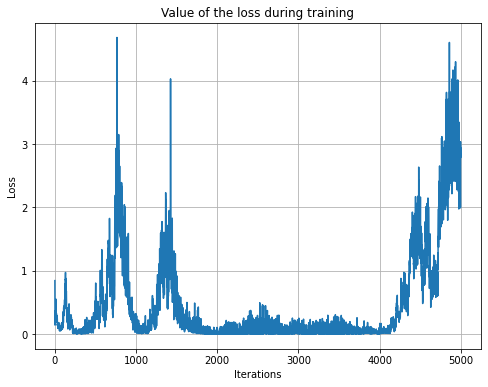

In [208]:
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Value of the loss during training")
plt.grid()
plt.show()

Idéalement, les valeurs de la fonctions de perte devraient d'abord **diminuer fortement** (phase d'optimisation, ou *burn-in*), puis fluctuer autour d'une valeur proche de 0 (phase d'échantillonage).

On observe un comportement radicalement différent, et très sensible aux hyperparamètres utilisés pour l'algorithme.

In [209]:
# hparams = dict(input_size=2)
# ensemble_model = EnsembleNet(params, SimpleDenseNet, hparams)

hparams = dict(input_size=2, hidden_size=4)
ensemble_model = EnsembleNet(params, DenseNet, hparams)

Accuracy : 98.93333435058594


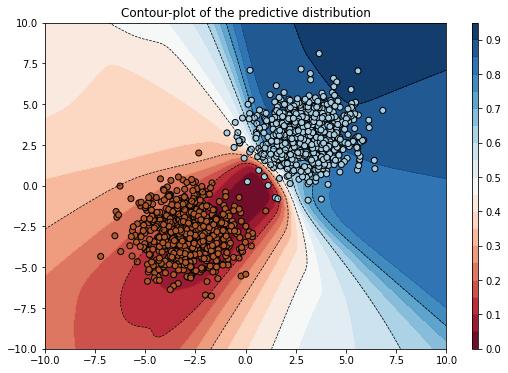

In [210]:
X_tens = torch.tensor(X.astype(np.float32))
y_tens = torch.tensor(y).reshape(-1, 1)

acc = 100 * torch.sum((ensemble_model(X_tens) > 0.5) == y_tens) / X_tens.size(0)
print(f"Accuracy : {acc}")
# limits
xlim, ylim = (-4, 12), (-4, 12)

# contour of the predictive distribution
xs = torch.linspace(-10, 10, 100)
ys = torch.linspace(-10, 10, 100)
xx, yy = torch.meshgrid(xs, ys)
zz = torch.tensor([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
ZZ = ensemble_model(zz)
ZZ = ZZ.reshape(xx.shape)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# contour of the predictive distribution
xs = xs.detach().numpy()
ys = ys.detach().numpy()
ZZ = ZZ.detach().numpy()
cont = ax.contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min().item(), vmax=ZZ.max().item(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax.contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax.set_title("Contour-plot of the predictive distribution");

plt.show()

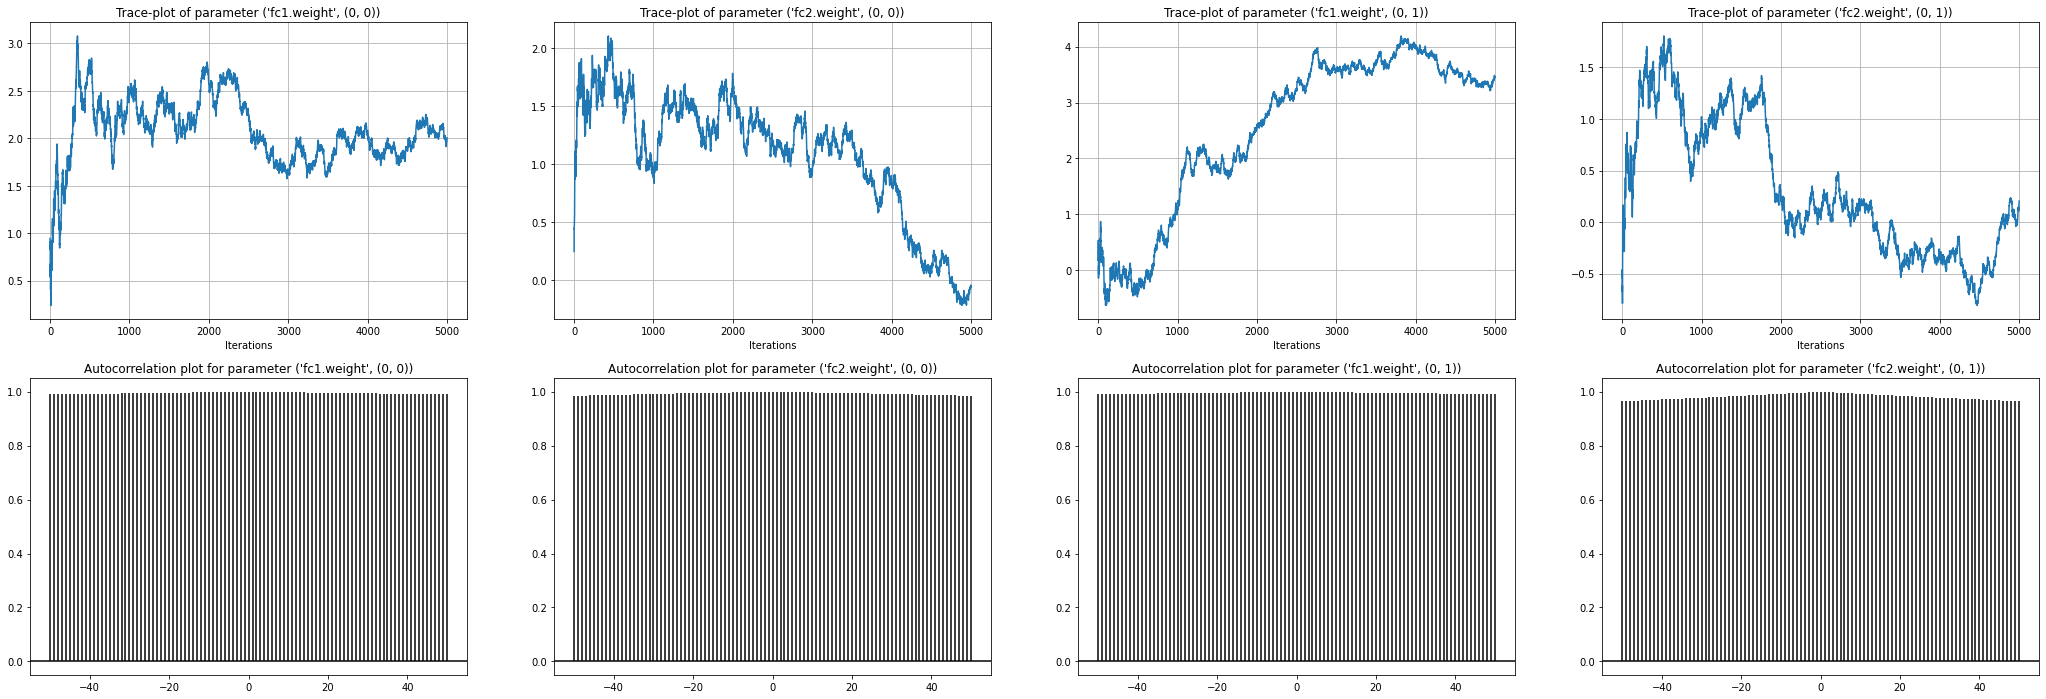

In [212]:
param_names = [('fc1.weight', (0, 0)), ('fc2.weight', (0, 0)), ('fc1.weight', (0, 1)), ('fc2.weight', (0, 1))]
traces = []
for name, idx in param_names:
    traces.append([param[name][idx] for param in params])

fig, ax = plt.subplots(2, 4, figsize=(9*4, 6*2))
for i, (trace, name) in enumerate(zip(traces, param_names)):
    ax[0, i].plot(trace)
    ax[0, i].set_title(f'Trace-plot of parameter {name}')
    ax[0, i].set_xlabel("Iterations")
    ax[0, i].grid()

    ax[1, i].acorr(trace, maxlags=50, color='k')
    ax[1, i].set_title(f'Autocorrelation plot for parameter {name}')

### Données non linéairement séparables

Par curiosité, tentons d'appliquer nos modèles sur un jeu de données, plus complexe, non linéairement séparable.

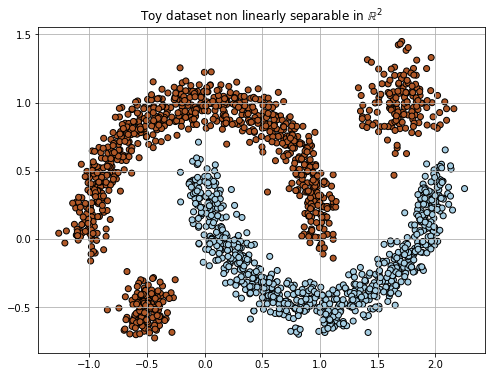

In [215]:
# load non linearly separable dataset
X, y = make_moons(n_samples=1500, noise=.09)
x1, y1 = multivariate_normal.rvs(mean=[1.7,1], cov=.03*np.eye(2), size=150), np.zeros(150)
x2, y2 = multivariate_normal.rvs(mean=[-.5,-.5], cov=.01*np.eye(2), size=150), np.zeros(150)
X = np.concatenate((X, x1, x2), axis=0)
y = np.concatenate((y, y1, y2), axis=0)
y = 2 * y - 1

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Paired_r', edgecolors='k')
plt.title("Toy dataset non linearly separable in $\mathbb{R}^2$")
plt.grid()
plt.show()

In [226]:
n_iter = 5000
batch_size = 15
a = 1e-2
b = 1
gamma = .7
sig = 100

model = DenseNet(input_size=2, hidden_size=4)
# model = SimpleDenseNet(input_size=2)

model, losses, params = SGLD_nn(X, y, n_iter, a, b, gamma, batch_size, sig, model, N_models=n_iter)

100%|██████████| 5000/5000 [00:07<00:00, 653.03it/s]


Done in 7.66 s.


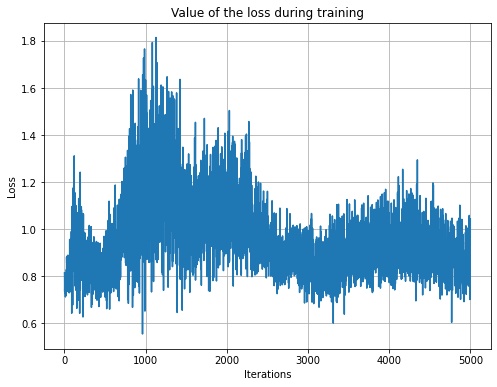

In [227]:
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Value of the loss during training")
plt.grid()
plt.show()

In [228]:
# hparams = dict(input_size=2)
# ensemble_model = EnsembleNet(params, SimpleDenseNet, hparams)

hparams = dict(input_size=2, hidden_size=4)
ensemble_model = EnsembleNet(params, DenseNet, hparams)

Accuracy : 15.666666984558105


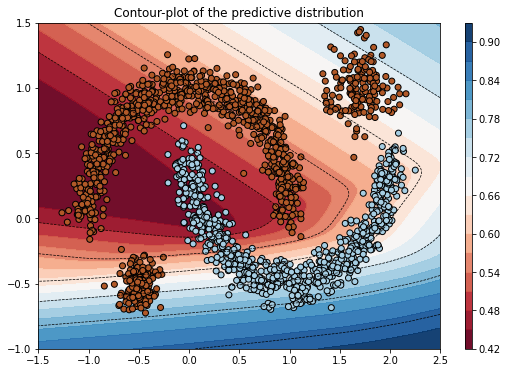

In [229]:
X_tens = torch.tensor(X.astype(np.float32))
y_tens = torch.tensor(y).reshape(-1, 1)

acc = 100 * torch.sum((ensemble_model(X_tens) > 0.5) == y_tens) / X_tens.size(0)
print(f"Accuracy : {acc}")
# limits
xlim, ylim = (-4, 12), (-4, 12)

# contour of the predictive distribution
xs = torch.linspace(-1.5, 2.5, 100)
ys = torch.linspace(-1, 1.5, 100)
xx, yy = torch.meshgrid(xs, ys)
zz = torch.tensor([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
ZZ = ensemble_model(zz)
ZZ = ZZ.reshape(xx.shape)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# contour of the predictive distribution
xs = xs.detach().numpy()
ys = ys.detach().numpy()
ZZ = ZZ.detach().numpy()
cont = ax.contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min().item(), vmax=ZZ.max().item(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax.contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax.set_title("Contour-plot of the predictive distribution");

plt.show()